# 3DMNN
#### EXPERIMENTS

In [2]:
import os.path as osp
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/viktorv/Projects/3DMNN/main/models/latent_space/src")

from classes.autoencoder import Configuration as Conf
from classes.gan import ConfigurationGAN as ConfGAN
from classes.pointnet_ae import PointNetAutoEncoder

from utils.templates import innofair_architecture
from utils.templates import autoencoder_paper, default_train_params
from utils.io import obj_wrapper, generate_mitsuba_xml

from utils.io import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from utils.utils import reset_tf_graph
from classes.latent_gan import LatentGAN

top_out_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data'          # Use to save Neural-Net check-points etc.
top_in_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

#class_name = input('Give me the class name (e.g. "chair"): ').lower()
class_name = "airplane"

syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir, syn_id)

all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

# train_params = default_train_params()

# encoder, decoder, enc_args, dec_args = autoencoder_paper(n_pc_points, bneck_size)


# conf = Conf(
#     n_input = [n_pc_points, 3],
#     loss = ae_loss,
#     training_epochs = 69,
#     batch_size = train_params['batch_size'],
#     denoising = train_params['denoising'],
#     learning_rate = train_params['learning_rate'],
#     train_dir = train_dir,
#     loss_display_step = train_params['loss_display_step'],
#     saver_step = train_params['saver_step'],
#     z_rotate = train_params['z_rotate'],
#     encoder = encoder,
#     decoder = decoder,
#     encoder_args = enc_args,
#     decoder_args = dec_args
# )
# conf.experiment_name = experiment_name
# conf.held_out_step = 5   # How often to evaluate/print out loss on 
#                          # held_out data (if they are provided in ae.train() ).
# conf.save(osp.join(train_dir, 'configuration'))

# reset_tf_graph()
# ae = PointNetAutoEncoder(conf.experiment_name, conf)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

conf = Conf.load(train_dir + "/configuration")
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False

reset_tf_graph()

ae = PointNetAutoEncoder(conf.experiment_name, conf)
ae.restore_model(conf.train_dir, 10, verbose=False)

buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

<generator object files_in_subdirs at 0x7f9a284cc360>
4045 pclouds were loaded. They belong in 1 shape-classes.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/single_class_ae/models.ckpt-10
Epoch: 0011 training time (minutes)= 0.2706 loss= 0.043360965
Epoch: 0012 training time (minutes)= 0.2528 loss= 0.039402440
Epoch: 0013 training time (minutes)= 0.2530 loss= 0.039351557
Epoch: 0014 training time (minutes)= 0.2531 loss= 0.038678695
Epoch: 0015 training time (minutes)= 0.2532 loss= 0.039132061
Epoch: 0016 training time (minutes)= 0.2534 loss= 0.038443989
Epoch: 0017 training time (minutes)= 0.2532 loss= 0.038484954
Epoch: 0018 training time (minutes)= 0.2531 loss= 0.037860367
Epoch: 0019 training time (minutes)= 0.2532 loss= 0.037640555
Epoch: 0020 training time (minutes)= 0.2532 loss= 0.037496208
INFO:tenso

Trained a simple point net auto encoder... Define reconstruct and interpolate functions

In [7]:
print(all_pc_data.point_clouds[-1].shape)

import random as rd

from_int = rd.randint(0, 4000)
to_int = rd.randint(0, 4000)

reconstruction_from = np.asarray(ae.reconstruct(all_pc_data.point_clouds[from_int].reshape(1,2048,3)))
reconstruction_to = np.asarray(ae.reconstruct(all_pc_data.point_clouds[to_int].reshape(1,2048,3)))

#data for the latent gan
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)

def reconstruct_obj(reconstructions):
    print("Reconstruction item shape:", reconstructions[0].shape)
    
    for i, reconstruction in enumerate(reconstructions):
        obj_wrapper(reconstruction, class_name, i)
        
    print("Reconstructed")

def interpolate(_from, _to, steps=10):
    
    print("Generating interpolations")
    print(_from.shape)
    print(_to.shape)
    
    interpolations = ae.interpolate(_from, _to, steps)

    for i, interpolation in enumerate(interpolations):
        obj_wrapper(interpolation, class_name + "_intr", i)
        generate_mitsuba_xml(interpolation, class_name, i, variation=False)
        
    print("Interpolation Complete")
    print(interpolations.shape)

reconstruct_obj(reconstruction_from[0])
reconstruct_obj(reconstruction_to[0])

interpolate(reconstruction_from[0], reconstruction_to[0], steps=60)

(2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed
Reconstruction item shape: (2048, 3)
Reconstructed
Generating interpolations
(1, 2048, 3)
(1, 2048, 3)
Interpolation Complete
(62, 2048, 3)


Create and Configure GAN...

In [4]:
generator, discriminator, params = innofair_architecture(128)

print(latent_codes.shape)
print(params)
# TODO:
# 5. Implement Conditional GAN in the LGAN

reset_tf_graph()
gan = LatentGAN(experiment_name, params['init_lr'], params['lambda'], params['n_out'],\
                params['noise_dim'], discriminator, generator, beta=params['beta'])


(4045, 128)
{'init_lr': 0.0001, 'lambda': 10, 'n_out': [128], 'noise_dim': 128, 'beta': 0.5, 'batch_size': 50, 'noise_params': {'mu': 0, 'sigma': 0.2}}
Calculating initial GP...


1 (-11.11039420068264, -1.10991715406999)
INFO:tensorflow:./models_checkpoints/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (-21.168934202194215, -4.521442040801048)
3 (-20.618171787261964, -5.658818036317825)
4 (-19.613165378570557, -6.4433320462703705)
5 (-18.534200859069824, -7.1489532589912415)
INFO:tensorflow:./models_checkpoints/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.
6 (-17.374555039405823, -7.862632781267166)
7 (-16.20088896751404, -8.467827558517456)
8 (-15.006587707996369, -9.00988256931305)
9 (-13.841587162017822, -9.39253431558609)
10 (-12.717622113227844, -9.670031726360321)
INFO:tensorflow:./models_checkpoints/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
11 (-11.655129206180572, -9.731855690479279)
12 (-10.652540910243989, -9.668142974376678)
13 (-9.75024834871292, -9.482745289802551)
14 (-8.907664895057678, -9.103304922580719)
15 (-8.188510918617249, -8.550906479358673)
16 (-7.547034

170 (-1.5305908009409905, -1.0534857735037804)
171 (-1.546543788909912, -0.8587896525859833)
172 (-1.5237501233816146, -0.9729094579815865)
173 (-1.551976963877678, -1.027789331972599)
174 (-1.5181422352790832, -1.077586505562067)
175 (-1.524269124865532, -1.2073467746376991)
176 (-1.5301466152071952, -1.2011443600058556)
177 (-1.5120628982782365, -1.1638866066932678)
178 (-1.5301132097840309, -1.377164363861084)
179 (-1.5251221880316734, -1.3628955781459808)
180 (-1.4973483294248582, -1.2709072902798653)
181 (-1.5140518367290496, -1.4492236077785492)
182 (-1.503779624402523, -1.4676883295178413)
183 (-1.5078518256545066, -1.4004126861691475)
184 (-1.4825886711478233, -1.5598023682832718)
185 (-1.4975300550460815, -1.5446191728115082)
186 (-1.488035435974598, -1.5971290841698647)
187 (-1.4844675585627556, -1.6534253805875778)
188 (-1.4808056309819222, -1.5175741240382195)
189 (-1.4854475200176238, -1.5976564809679985)
190 (-1.469952829182148, -1.5331216305494308)
191 (-1.47348964661359

339 (-1.5191438540816307, -0.19986229640198871)
340 (-1.527882181107998, -0.2344770599156618)
341 (-1.5062526866793633, -0.17684393748641014)
342 (-1.5109528228640556, -0.28686348581686616)
343 (-1.5005390062928199, -0.2861213064752519)
344 (-1.4886487603187561, -0.24776817206293344)
345 (-1.4987476214766502, -0.24503393576014787)
346 (-1.5144550532102585, -0.2565546128898859)
347 (-1.5214122265577317, -0.1560709998011589)
348 (-1.504649668931961, -0.15627936192322522)
349 (-1.5143623128533363, -0.19601799617521465)
350 (-1.5159119471907616, -0.19975191494449973)
INFO:tensorflow:./models_checkpoints/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.
351 (-1.4963738709688186, -0.21027168491855264)
352 (-1.4939946100115775, -0.1308543556369841)
353 (-1.4912047892808915, -0.12185678145033307)
354 (-1.485396322607994, -0.10364516248228028)
355 (-1.5094994723796844, -0.1731412111548707)
356 (-1.507911702990532, -0.13044344380614348)
357 (-1.5106068789958953, -0.106450

505 (-1.4492149844765663, 0.1447315582772717)
506 (-1.4401142716407775, 0.12718600878724828)
507 (-1.4289277523756028, 0.18842947110533714)
508 (-1.4429355680942535, 0.18044681893661618)
509 (-1.4415692195296288, 0.1960255944286473)
510 (-1.4379020795226096, 0.12632217866485007)
511 (-1.4370454475283623, 0.177093350677751)
512 (-1.4527721896767616, 0.1851158591452986)
513 (-1.4257011711597443, 0.17017092555761337)
514 (-1.4401242300868033, 0.12304343504365534)
515 (-1.4354435443878173, 0.13900160125922412)
516 (-1.4337724715471267, 0.19864733633585274)
517 (-1.4327684476971627, 0.15198513254290447)
518 (-1.4411213636398315, 0.1553801415138878)
519 (-1.4458683595061301, 0.12441182066686451)
520 (-1.4421064764261247, 0.10243478766642511)
521 (-1.4215781569480896, 0.11334585137228714)
522 (-1.4243641778826714, 0.15668029244989157)
523 (-1.4338918536901475, 0.08141764649190009)
524 (-1.428364783525467, 0.12092262652004138)
525 (-1.4490818485617638, 0.14841114194132388)
526 (-1.434992767870

675 (-1.359178288280964, 0.14745311252772808)
676 (-1.3594630360603333, 0.09532765556650702)
677 (-1.3614374071359634, 0.10322464216733351)
678 (-1.3638781130313873, 0.1441953723988263)
679 (-1.3530161499977111, 0.14396129781380296)
680 (-1.3631396055221559, 0.15492528676986694)
681 (-1.3854683980345726, 0.158472420880571)
682 (-1.3742989495396614, 0.1612841773312539)
683 (-1.3769818887114524, 0.15854192763799801)
684 (-1.379827728867531, 0.13667325186543167)
685 (-1.3690607234835626, 0.18219722632784396)
686 (-1.3724676921963692, 0.1944952728226781)
687 (-1.3761146888136864, 0.10530130616098177)
688 (-1.3501442313194274, 0.1859806685242802)
689 (-1.3610592037439346, 0.15494827646762133)
690 (-1.3653590679168701, 0.10983686208055587)
691 (-1.3901802584528924, 0.12040381234692177)
692 (-1.3677613288164139, 0.12605256825918332)
693 (-1.3631318151950835, 0.16457249713130295)
694 (-1.3553221300244331, 0.1342360539129004)
695 (-1.3611540272831917, 0.22656305925920606)
696 (-1.36350355893373

844 (-1.3343359768390655, 0.06214911052666139)
845 (-1.3229350745677948, 0.013377416209550574)
846 (-1.3248690135776997, 0.03176723752403632)
847 (-1.3206647291779519, 0.08445213560480624)
848 (-1.3179303973913192, 0.11033912294078618)
849 (-1.3204377055168153, 0.05112013372126967)
850 (-1.2993462428450584, 0.06917199036251986)
INFO:tensorflow:./models_checkpoints/models.ckpt-850 is not in all_model_checkpoint_paths. Manually adding it.
851 (-1.3226744309067726, 0.04704846817185171)
852 (-1.2950292073190213, 0.09280469547957182)
853 (-1.3237572848796844, 0.03544350096490234)
854 (-1.3055216453969478, -0.009440830297535285)
855 (-1.3110467128455638, 0.03531434154865565)
856 (-1.3086973764002323, -0.0019070978451054543)
857 (-1.3072405338287354, -0.0010502909135539085)
858 (-1.3092715099453927, 0.029038242479145993)
859 (-1.291250030696392, 0.03927717061014846)
860 (-1.327886413037777, 0.018608340993523598)
861 (-1.3172553911805154, 0.015322887353249826)
862 (-1.3188977599143983, 0.08870

/home/viktorv/.conda/envs/3dmnn_cu9/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


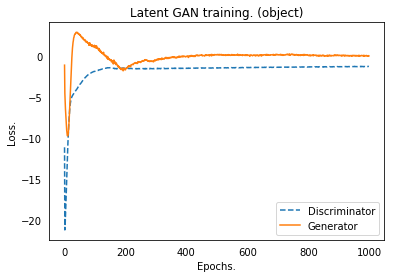

In [5]:
accum_syn_data = []
train_stats = []
n_epochs = 1000
# Train the GAN.
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])
latent_data = PointCloudDataSet(latent_codes)

gan.train(latent_data, params, n_epochs, "./models_checkpoints/", save_gan_model=True, \
          saver_step=saver_step, train_stats=train_stats)

In [6]:
syn_latent_data = gan.generate(10, params["noise_params"])
print(syn_latent_data.shape)

syn_data = []
for vector in syn_latent_data:
    syn_data.append(ae.decode(vector))
    
syn_data = np.asarray(syn_data).reshape((10,2048,3))
print(syn_data.shape)

reconstruct_obj(syn_data)
for i, data in enumerate(syn_data):
    generate_mitsuba_xml(data, class_name + "_gen", i)


(10, 128)
(10, 2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed


# TODO
### 1. Rewrite CONF Class to fit GANs - DONE
### 2. Implement Discriminator, Generator for the simple LGAN - DONE
### 3. Train
### 4. Try to decode something generated
### 5. Implement Conditional GAN in the LGAN 
### 6. Go to 3 and 4 again